In [1]:
## This script performs simulations that inform the timing requirements for the proposed Digital Noise Source...
## This started from a script sent around by Kevin Bandura (henceforth KB)

## Begin with import statements from Kevin:
import numpy as np
from matplotlib.pyplot import *
from scipy.special import erf
import math
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

In [316]:
def quantizer(a, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    # Now assumes a complex number as well.  
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    scaling1 = desired_rms/(a.real).std()
    quantized_a_real = np.round((a.real)*scaling1,0)
    high_mask = (quantized_a_real > max_high)
    quantized_a_real[high_mask] = max_high
    low_mask = (quantized_a_real < max_low)
    quantized_a_real[low_mask] = max_low
    quantized_a_imag = np.round((a.imag)*scaling1,0)
    high_mask = (quantized_a_imag > max_high)
    quantized_a_imag[high_mask] = max_high
    low_mask = (quantized_a_imag < max_low)
    quantized_a_imag[low_mask] = max_low
    quantized_a = quantized_a_real + 1.0j*quantized_a_imag
    return quantized_a

def quantizer_WT(a, scaling=None, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    if scaling==None:
        scaling1 = desired_rms/a.std()
    elif type(scaling)==np.float64:
        scaling1=scaling
    quantized_a_real = np.round((a.real)*scaling1,0)
    high_mask = (quantized_a_real > max_high)
    quantized_a_real[high_mask] = max_high
    low_mask = (quantized_a_real < max_low)
    quantized_a_real[low_mask] = max_low
    quantized_a_imag = np.round((a.imag)*scaling1,0)
    high_mask = (quantized_a_imag > max_high)
    quantized_a_imag[high_mask] = max_high
    low_mask = (quantized_a_imag < max_low)
    quantized_a_imag[low_mask] = max_low
    quantized_a = quantized_a_real + 1.0j*quantized_a_imag
    return quantized_a

def quantizer_WT_scaling(a, nbits=8):
    # a assumed to be signal in 'lsb's' but continuous
    nlevels = 2**nbits
    max_high = nlevels/2 - 1
    max_low = -1.0*nlevels/2
    #do easy but imperfect scaling to have std be nbits/2
    desired_rms = 2**(nbits/2)
    scaling1 = desired_rms/a.std()
    return scaling1

## Functions for Index Shift and Phase Shift from total timing difference:
# Each time index is 2.56us, we want total time/2.56us to give us the number of indices, ignoring remainder.
# Each phase shift depends on frequency... each 2pi occurs on timescale 1/f, want remainder to find phase shift

def Index_Shift_From_Time(time_array):
    return (time_array/(2.56e-6)).astype(int)
    
def Phase_Shift_From_Time(time_array,frequency):
    return time_array/(frequency**-1.0)#%(2*np.pi)

## Sources of time delay:
## 1) Freespace drone to telescope (depends on position, max when drone+telescope same altitude, time is dist/c)
## 2) Frontend telescope cables (time is length/0.85c)
## 3) Jitter from clock variations?

## What should our total lag time be? (This is the quasi-fixed lag between a drone signal and a correlator signal)
## How big should we expect our free-space lags to be?
SOL=299792458.0  #m/s
typdist=np.sqrt((100.0**2.0)+(175.0**2.0))
FS_Lag=typdist/SOL
print("A reasonable estimate for the FS_Lag is {:.4f}us".format(1e6*FS_Lag))
print(" --> During tests at GBO the drone was typically less than {:.2f} m away".format(typdist))
print(" --> This corresponds to a free-space lag of {:.4f}us".format(1e6*typdist/SOL))
## How big should we expect our front-end lags to be?
FE_Lag=100.0/(0.85*SOL)
print("A reasonable estimate for the FE_Lag is {:.4f}s".format(1e6*FE_Lag))
print(" --> If there are 100m of cable the front-end lag should be {:.4f}us".format(1e6*100.0/(0.85*SOL)))
## And thus the total is...?
print("A reasonable estimate for the Total_Lag=FS_Lag+FE_Lag is {:.4f}us".format(1e6*(FS_Lag+FE_Lag)))
## How far would the drone need to be to account for an index shift if we include front-end lag?
print("The drone would need to be {:.2f} m away to account for a 1 index shift".format(SOL*(2.56e-6-FE_Lag)))

t_length=16384
## What about jitter? Kevin seems to think that over hours 10s of ns is a reasonable jitter to expect...
clk_jitter_100ns=np.abs(np.random.normal(0,10e-9,t_length))
clk_jitter_100ps=np.abs(np.random.normal(0,100e-12,t_length))
print("Average simulated jitter on 1 hour timescales is {:.4f}ns".format(np.nanmean(clk_jitter_100ns)*1e9))
print("Average simulated jitter on 2.56us timescales is {:.4f}ps".format(np.nanmean(clk_jitter_100ps)*1e12))

## DEFN the Gauss Fit function:
def Gauss(x,a,x0,sigma,k):
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k

A reasonable estimate for the FS_Lag is 0.6723us
 --> During tests at GBO the drone was typically less than 201.56 m away
 --> This corresponds to a free-space lag of 0.6723us
A reasonable estimate for the FE_Lag is 0.3924s
 --> If there are 100m of cable the front-end lag should be 0.3924us
A reasonable estimate for the Total_Lag=FS_Lag+FE_Lag is 1.0647us
The drone would need to be 649.82 m away to account for a 1 index shift
Average simulated jitter on 1 hour timescales is 7.9682ns
Average simulated jitter on 2.56us timescales is 79.9330ps


In [215]:
## 2) Looping through 1000 of same jitter to test noise properties for Kalyani's new metric:
stop
## Select fixed params that dictate run properties:
fman=727e6 #select freq
#t_length=16384
t_length=65536
inputpower=2**5.5
iteration_space=np.arange(1000)
#jitter_space=np.linspace(1e-12,15e-9,1000)
jitter_space=np.linspace(1e-12,4e-9,50)
#gain_space=np.linspace(0.25,24.7,100)
gain_space=np.linspace(0.05,2.2,100)

## Define parameter arrays that we want to pull out for each jitter we test:
q_sig_scaling=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
q_corr_scaling=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
input_phase=np.zeros((len(jitter_space),len(gain_space),len(iteration_space)))
## Unquantized (f) correlations:
nq_max_ind_auto=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
nq_max_ind_cross=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
nq_max_mag_auto_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
nq_max_mag_auto_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
nq_max_mag_cross_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
nq_max_mag_cross_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
## Quantized (f) correlations:
q_max_ind_auto=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
q_max_ind_cross=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(int)
q_max_mag_auto_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
q_max_mag_auto_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
q_max_mag_cross_on=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)
q_max_mag_cross_off=np.zeros((len(jitter_space),len(gain_space),len(iteration_space))).astype(complex)

signal=np.random.normal(0,inputpower,(len(iteration_space),t_length))+(1.0j*np.random.normal(0,inputpower,(len(iteration_space),t_length)))
noise_term=np.random.normal(0,inputpower,(len(iteration_space),t_length))+(1.0j*np.random.normal(0,inputpower,(len(iteration_space),t_length)))
noise_term_off=np.random.normal(0,inputpower,(len(iteration_space),t_length))+(1.0j*np.random.normal(0,inputpower,(len(iteration_space),t_length)))

for i,iteration in enumerate(iteration_space):
    for g,gain in enumerate(gain_space):
        f_signal=signal[i]
        f_signal_on=(gain*signal[i])+noise_term[i]
        f_signal_off=noise_term_off[i]
        for j,jitter in enumerate(jitter_space):
            print('Iteration:{}/{}, Gain:{}/{}, Jitter:{}/{}    '.format(i+1,len(iteration_space),g+1,len(gain_space),j+1,len(jitter_space)),end='\r')
            ## Draw a sample to populate the jitter array and construct index shift/phase:
            simtimearr=(np.ones(t_length)*(FS_Lag+FE_Lag))+np.random.normal(0,jitter,t_length)
            index_shift=int(np.nanmedian(Index_Shift_From_Time(simtimearr)))
            phase_rads=Phase_Shift_From_Time(simtimearr,fman)
            input_phase[j,g,i]=np.nanmean(phase_rads)
            phase_array=np.exp(-1.0j*phase_rads)
            ## create the f and q arrays:
            f_signal_on_ps=np.roll(phase_array*f_signal_on,index_shift)
            f_signal_off_ps=np.roll(phase_array*f_signal_off,index_shift)
            #on_scaling=quantizer_WT_scaling(f_signal_on_ps,nbits=8)
            on_scaling=np.nanmin([0.25*127.0/np.nanmean(np.abs(np.real(f_signal_on_ps))),0.25*127.0/np.nanmean(np.abs(np.imag(f_signal_on_ps)))])
            sig_scaling=np.nanmin([0.25*127.0/np.nanmean(np.abs(np.real(f_signal))),0.25*127.0/np.nanmean(np.abs(np.imag(f_signal)))])
            q_sig_scaling[j,g,i]=sig_scaling
            q_corr_scaling[j,g,i]=on_scaling
            q_signal_on_ps=quantizer_WT(f_signal_on_ps,scaling=on_scaling,nbits=8)
            q_signal_off_ps=quantizer_WT(f_signal_off_ps,scaling=on_scaling,nbits=8)
            q_signal=quantizer_WT(f_signal,scaling=sig_scaling,nbits=8)
            ## Perform correlations (unquantized):
            nq_auto_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal_on_ps)))
            nq_auto_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal_off_ps)))
            nq_cross_corr_on_ps=np.fft.ifft(np.fft.fft(f_signal_on_ps)*np.conjugate(np.fft.fft(f_signal)))
            nq_cross_corr_off_ps=np.fft.ifft(np.fft.fft(f_signal_off_ps)*np.conjugate(np.fft.fft(f_signal)))
            ## Perform correlations (quantized):
            q_auto_corr_on_ps=np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal_on_ps)))
            q_auto_corr_off_ps=np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal_off_ps)))
            q_cross_corr_on_ps=np.fft.ifft(np.fft.fft(q_signal_on_ps)*np.conjugate(np.fft.fft(q_signal)))
            q_cross_corr_off_ps=np.fft.ifft(np.fft.fft(q_signal_off_ps)*np.conjugate(np.fft.fft(q_signal)))
            ## Populate loop auto variables (unquantized):
            nq_max_ind_auto[j,g,i]=np.where(np.abs(nq_auto_corr_on_ps)==np.nanmax(np.abs(nq_auto_corr_on_ps)))[0][0]
            nq_max_mag_auto_on[j,g,i]=nq_auto_corr_on_ps[nq_max_ind_auto[j,g,i]]
            nq_max_mag_auto_off[j,g,i]=nq_auto_corr_off_ps[nq_max_ind_auto[j,g,i]]
            nq_max_ind_cross[j,g,i]=np.where(np.abs(nq_cross_corr_on_ps)==np.nanmax(np.abs(nq_cross_corr_on_ps)))[0][0]
            nq_max_mag_cross_on[j,g,i]=nq_cross_corr_on_ps[nq_max_ind_cross[j,g,i]]
            nq_max_mag_cross_off[j,g,i]=nq_cross_corr_off_ps[nq_max_ind_cross[j,g,i]]               
            ## Populate loop cross variables (quantized):
            q_max_ind_auto[j,g,i]=np.where(np.abs(q_auto_corr_on_ps)==np.nanmax(np.abs(q_auto_corr_on_ps)))[0][0]
            q_max_mag_auto_on[j,g,i]=q_auto_corr_on_ps[q_max_ind_auto[j,g,i]]
            q_max_mag_auto_off[j,g,i]=q_auto_corr_off_ps[q_max_ind_auto[j,g,i]]
            q_max_ind_cross[j,g,i]=np.where(np.abs(q_cross_corr_on_ps)==np.nanmax(np.abs(q_cross_corr_on_ps)))[0][0]
            q_max_mag_cross_on[j,g,i]=q_cross_corr_on_ps[q_max_ind_cross[j,g,i]]
            q_max_mag_cross_off[j,g,i]=q_cross_corr_off_ps[q_max_ind_cross[j,g,i]]                  

/home/tyndall/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


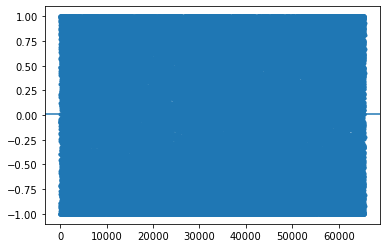

In [298]:
plot(np.real(phase_array),'.')
axhline(np.nanmean(phase_array))



In [219]:
stop
np.savez("./DNS_Sims_Run_i1000_g100_j50.npz",\
         q_sig_scaling=q_sig_scaling,\
         q_corr_scaling=q_corr_scaling,\
         nq_max_ind_auto=nq_max_ind_auto,\
         nq_max_mag_auto_on=nq_max_mag_auto_on,\
         nq_max_mag_auto_off=nq_max_mag_auto_off,\
         nq_max_ind_cross=nq_max_ind_cross,\
         nq_max_mag_cross_on=nq_max_mag_cross_on,\
         nq_max_mag_cross_off=nq_max_mag_cross_off,\
         q_max_ind_auto=q_max_ind_auto,\
         q_max_mag_auto_on=q_max_mag_auto_on,\
         q_max_mag_auto_off=q_max_mag_auto_off,\
         q_max_ind_cross=q_max_ind_cross,\
         q_max_mag_cross_on=q_max_mag_cross_on,\
         q_max_mag_cross_off=q_max_mag_cross_off)
        
        
dat=np.load("./DNS_Sims_Run_i1000_g100_j50.npz")
list(dat.keys())

['q_sig_scaling',
 'q_corr_scaling',
 'nq_max_ind_auto',
 'nq_max_mag_auto_on',
 'nq_max_mag_auto_off',
 'nq_max_ind_cross',
 'nq_max_mag_cross_on',
 'nq_max_mag_cross_off',
 'q_max_ind_auto',
 'q_max_mag_auto_on',
 'q_max_mag_auto_off',
 'q_max_ind_cross',
 'q_max_mag_cross_on',
 'q_max_mag_cross_off']

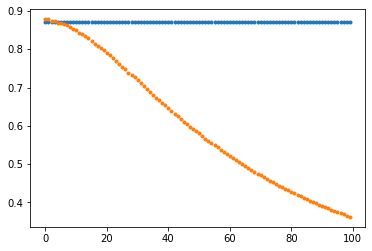

In [220]:
plot(q_sig_scaling[0,:,0],'.')
plot(q_corr_scaling[9,:,0],'.')

lol


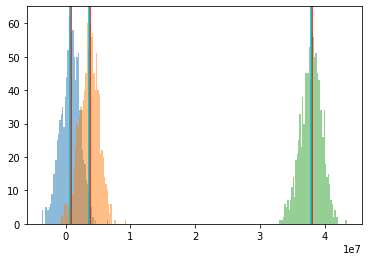

In [327]:
#hist((np.abs(nq_max_mag_auto_on[0,0,:])),bins=100,alpha=0.5,label='on')
#hist((np.abs(nq_max_mag_auto_off[0,0,:])),bins=100,alpha=0.5,label='off')

#nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
nnn=99
for nnn in [0,3,15]:
    hist(((nq_max_mag_auto_on[0,nnn,:])-(nq_max_mag_auto_off[0,nnn,:])),bins=50,alpha=0.5)
    axvline(np.nanmedian(((nq_max_mag_auto_on[0,nnn,:])-(nq_max_mag_auto_off[0,nnn,:]))),c='r')
    axvline(np.nanmean(((nq_max_mag_auto_on[0,nnn,:])-(nq_max_mag_auto_off[0,nnn,:]))),c='c')
print('lol')

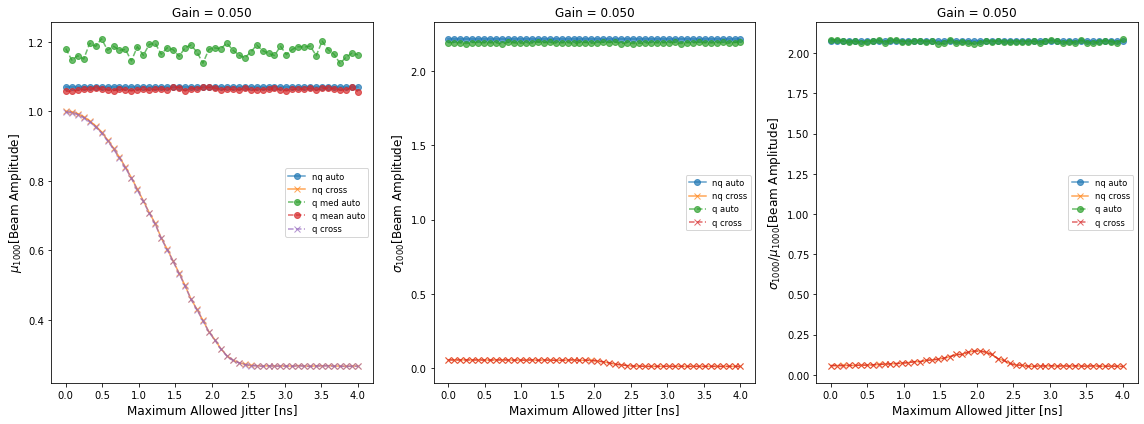

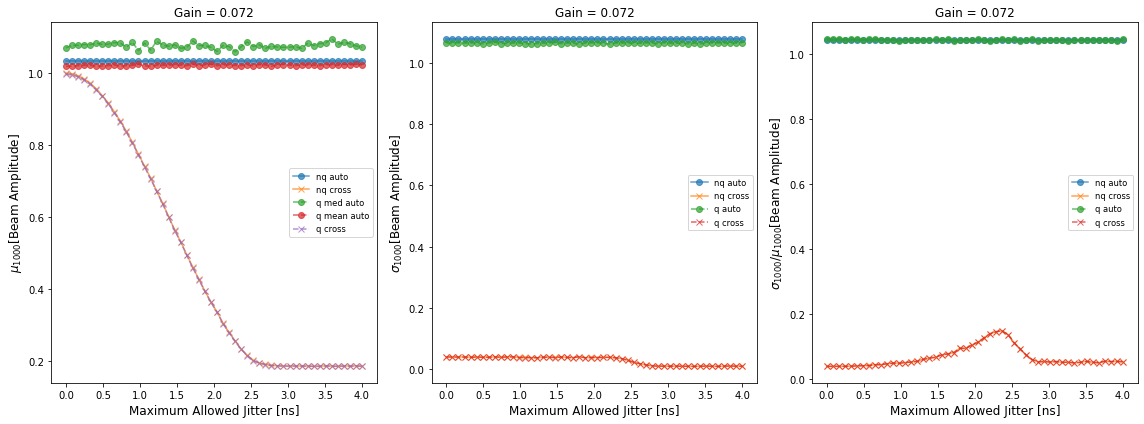

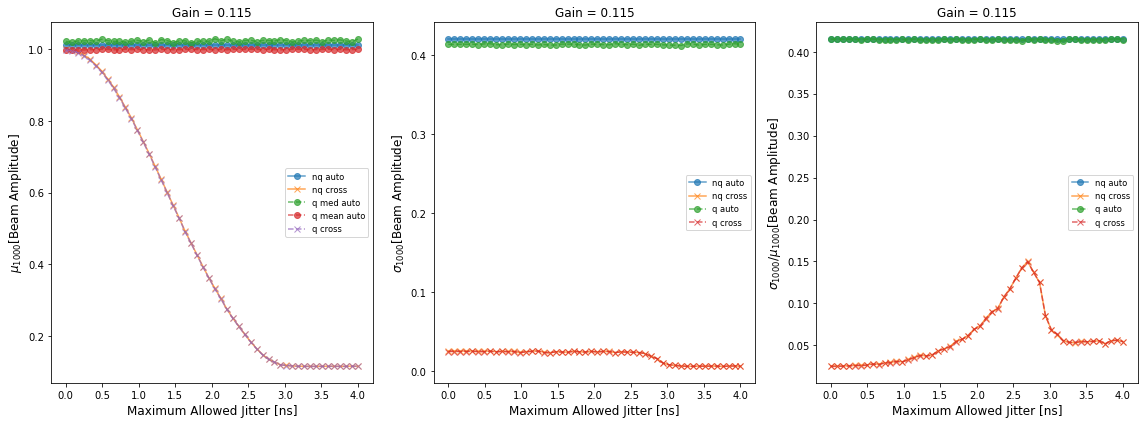

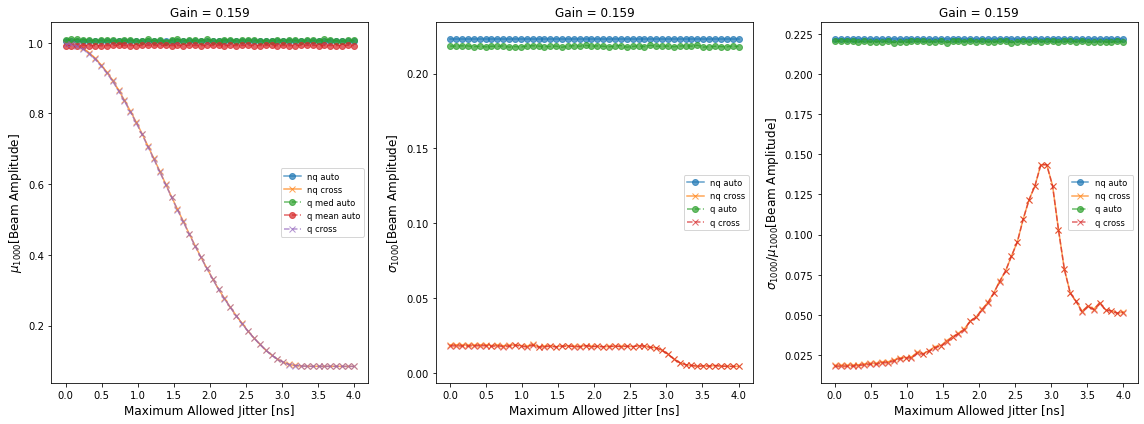

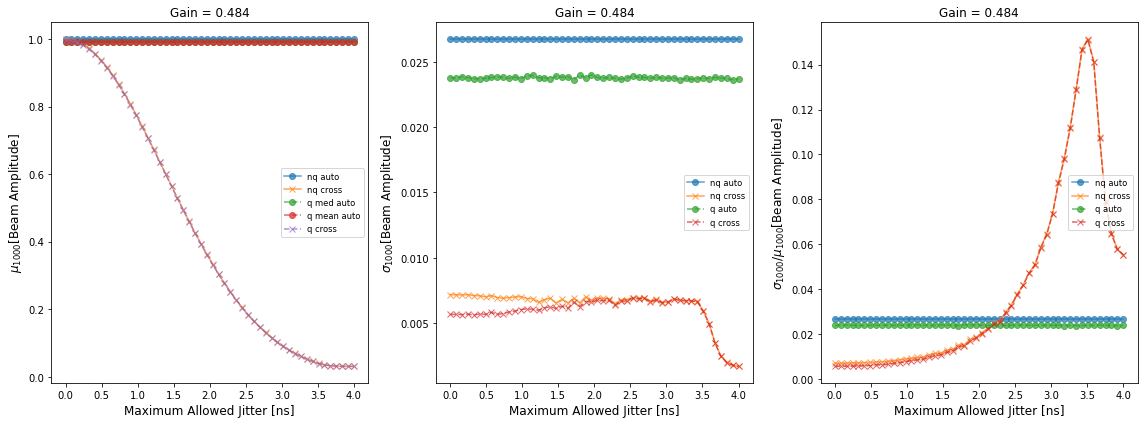

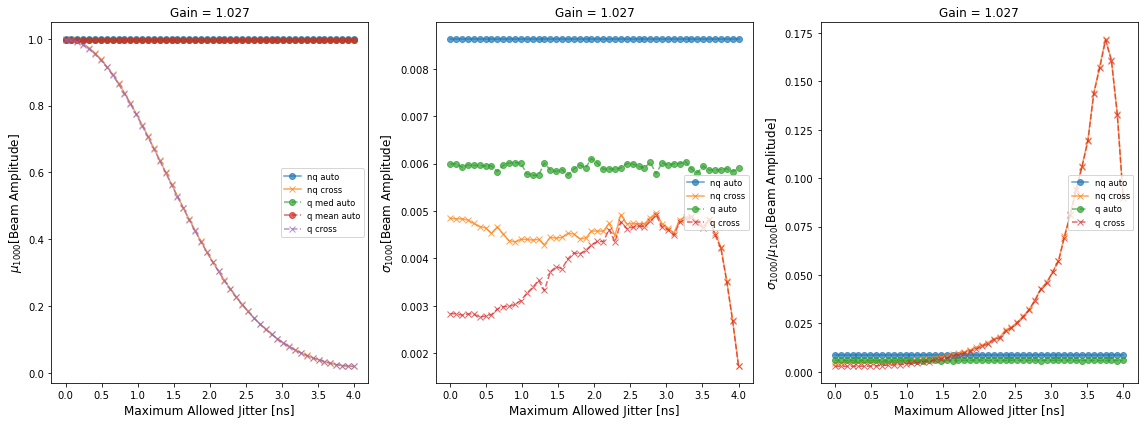

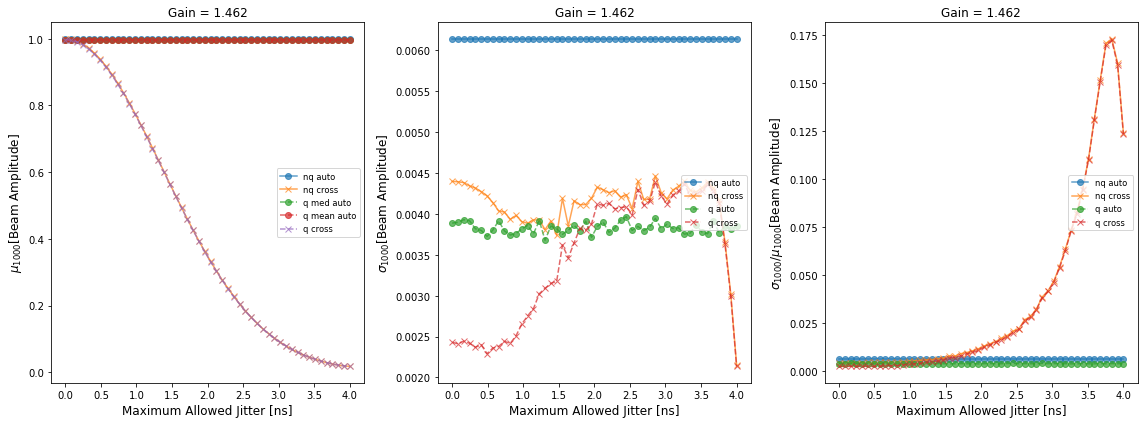

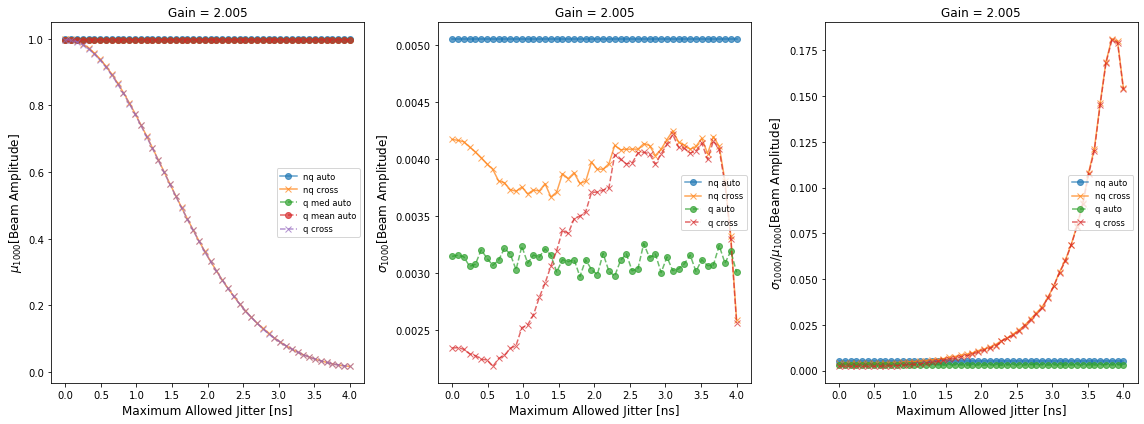

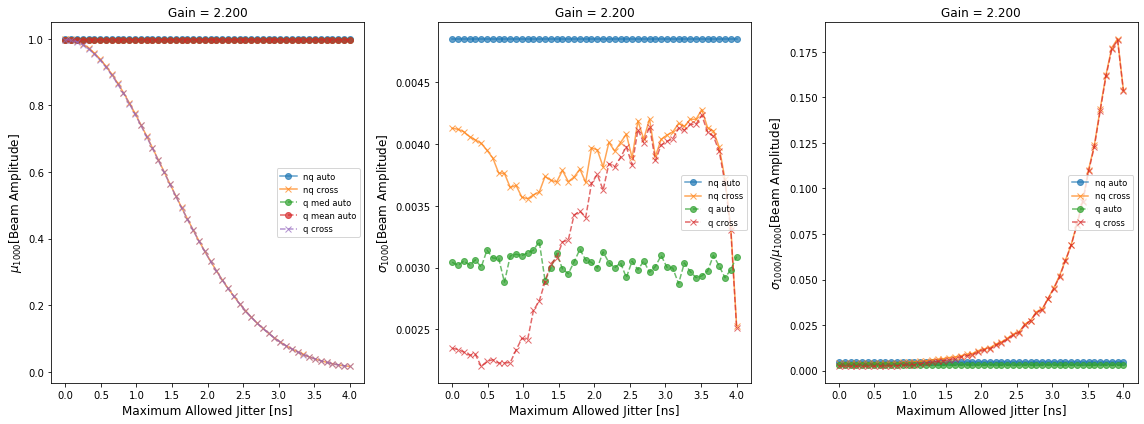

In [257]:
# Using Kalyani's recovered gain method:
for g in [0,1,3,5,20,45,65,90,99]:
    fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6))
    for k,ax in enumerate([ax1]):
        ## IF mult signal by gain:
        nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
        nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**1.0))
        #q_a_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length)*(gain_space[g]**2.0))
        #q_c_norm=1.0/(2*(inputpower**2.0)*np.nanmean(q_corr_scaling[:,g,:],axis=1)*np.nanmean(q_sig_scaling[:,g,:],axis=1)*(t_length)*(gain_space[g]**1.0))
        q_a_norm=1.0/(2*(inputpower**2.0)*(q_corr_scaling[:,g,:]**2.0)*(t_length)*(gain_space[g]**2.0))
        q_c_norm=1.0/(2*(inputpower**2.0)*q_corr_scaling[:,g,:]*q_sig_scaling[:,g,:]*(t_length)*(gain_space[g]**1.0))
        ## IF div noise by gain:
        #nq_norm=1.0/(2*(inputpower**2.0)*(t_length))
        #q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length))
        ax.set_title("Gain = {:.3f}".format(gain_space[g]),fontsize='large')
        nq_x=nq_a_norm*np.nanmean((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
        nq_y=nq_c_norm*np.nanmean(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)
        q_z=np.nanmedian((np.abs(q_a_norm[:,:]*q_max_mag_auto_on[:,g,:])-np.abs(q_a_norm[:,:]*q_max_mag_auto_off[:,g,:])),axis=1)
        q_x=np.nanmean((np.abs(q_a_norm[:,:]*q_max_mag_auto_on[:,g,:])-np.abs(q_a_norm[:,:]*q_max_mag_auto_off[:,g,:])),axis=1)
        q_y=np.nanmean(np.abs(q_c_norm[:,:]*q_max_mag_cross_on[:,g,:]),axis=1)

        
        
        #q_x=q_a_norm*np.nanmean((np.abs((q_corr_scaling[:,g,:]**2.0)*q_max_mag_auto_on[:,g,:])-np.abs((q_corr_scaling[:,g,:]**2.0)*q_max_mag_auto_off[:,g,:])),axis=1)        
        #q_y=q_c_norm*np.nanmean(np.abs((q_corr_scaling[:,g,:]*q_sig_scaling[:,g,:])*q_max_mag_cross_on[:,g,:]),axis=1)
        ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
        ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
        ax.plot(jitter_space*1e9,q_z,'o--',alpha=0.7,label='q med auto')
        ax.plot(jitter_space*1e9,q_x,'o--',alpha=0.7,label='q mean auto')
        ax.plot(jitter_space*1e9,q_y,'x--',alpha=0.7,label='q cross')
        ax.set_ylabel("$\mu_{1000}$[Beam Amplitude]",fontsize='large')
        ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
        ax.legend(loc=5,fontsize='small')
    for k,ax in enumerate([ax2]):
        ## IF mult signal by gain:
        nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
        nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**1.0))
        q_a_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length)*(gain_space[g]**2.0))
        q_c_norm=1.0/(2*(inputpower**2.0)*np.nanmean(q_corr_scaling[:,g,:],axis=1)*np.nanmean(q_sig_scaling[:,g,:],axis=1)*(t_length)*(gain_space[g]**1.0))
        ## IF div noise by gain:
        #nq_norm=1.0/(2*(inputpower**2.0)*(t_length))
        #q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length))
        ax.set_title("Gain = {:.3f}".format(gain_space[g]),fontsize='large')
        nq_x=nq_a_norm*np.nanstd((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
        nq_y=nq_c_norm*np.nanstd(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)
        q_x=q_a_norm*np.nanstd((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)
        q_y=q_c_norm*np.nanstd(np.abs(q_max_mag_cross_on[:,g,:]),axis=1)
        ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
        ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
        ax.plot(jitter_space*1e9,q_x,'o--',alpha=0.7,label='q auto')
        ax.plot(jitter_space*1e9,q_y,'x--',alpha=0.7,label='q cross')
        ax.set_ylabel("$\sigma_{1000}$[Beam Amplitude]",fontsize='large')
        ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
        ax.legend(loc=5,fontsize='small')
    for k,ax in enumerate([ax3]):
        ## IF mult signal by gain:
        nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**2.0))
        nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[g]**1.0))
        q_a_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length)*(gain_space[g]**2.0))
        q_c_norm=1.0/(2*(inputpower**2.0)*np.nanmean(q_corr_scaling[:,g,:],axis=1)*np.nanmean(q_sig_scaling[:,g,:],axis=1)*(t_length)*(gain_space[g]**1.0))
        ## IF div noise by gain:
        #nq_norm=1.0/(2*(inputpower**2.0)*(t_length))
        #q_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[:,g,:],axis=1)**2.0)*(t_length))
        ax.set_title("Gain = {:.3f}".format(gain_space[g]),fontsize='large')
        nq_x=np.nanstd((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)/np.nanmean((np.abs(nq_max_mag_auto_on[:,g,:])-np.abs(nq_max_mag_auto_off[:,g,:])),axis=1)
        nq_y=np.nanstd(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)/np.nanmean(np.abs(nq_max_mag_cross_on[:,g,:]),axis=1)
        q_x=np.nanstd((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)/np.nanmean((np.abs(q_max_mag_auto_on[:,g,:])-np.abs(q_max_mag_auto_off[:,g,:])),axis=1)
        q_y=np.nanstd(np.abs(q_max_mag_cross_on[:,g,:]),axis=1)/np.nanmean(np.abs(q_max_mag_cross_on[:,g,:]),axis=1)
        ax.plot(jitter_space*1e9,nq_x,'o-',alpha=0.7,label='nq auto')
        ax.plot(jitter_space*1e9,nq_y,'x-',alpha=0.7,label='nq cross')
        ax.plot(jitter_space*1e9,q_x,'o--',alpha=0.7,label='q auto')
        ax.plot(jitter_space*1e9,q_y,'x--',alpha=0.7,label='q cross')
        ax.set_ylabel("$\sigma_{1000}$/$\mu_{1000}$[Beam Amplitude]",fontsize='large')
        ax.set_xlabel('Maximum Allowed Jitter [ns]',fontsize='large')
        ax.legend(loc=5,fontsize='small')
    tight_layout()

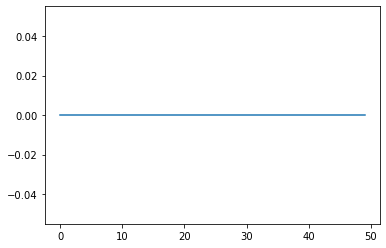

In [365]:
plot(np.nanmean(q_max_ind_auto[:,0,:],axis=1))

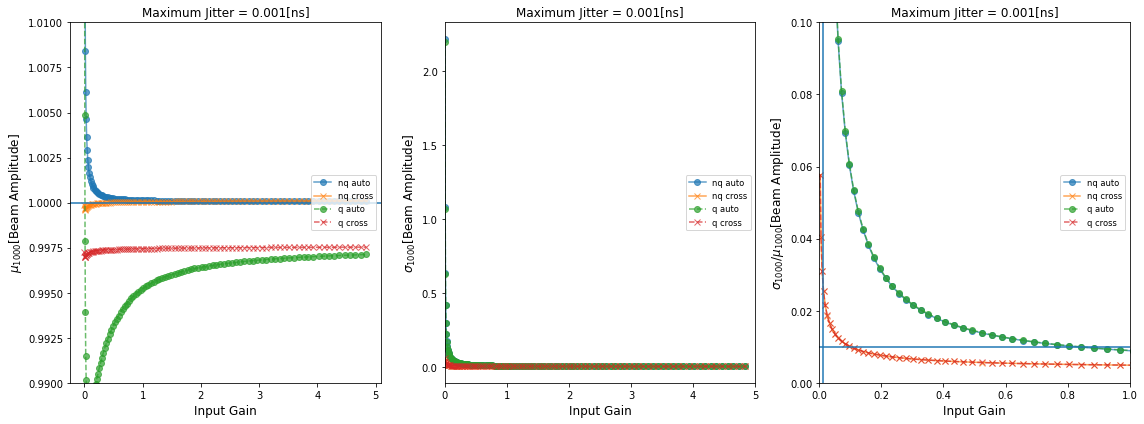

In [362]:
fig,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6))
for j in [0]:
    ## AX 1 Mean
    nq_a_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[:]**2.0))
    nq_c_norm=1.0/(2*(inputpower**2.0)*(t_length)*(gain_space[:]**1.0))
    #q_a_norm=1.0/(2*(inputpower**2.0)*(np.nanmean(q_corr_scaling[j,:,:],axis=1)**2.0)*(t_length)*(gain_space[:]**2.0))
    #q_c_norm=1.0/(2*(inputpower**2.0)*np.nanmean(q_corr_scaling[j,:,:],axis=1)*np.nanmean(q_sig_scaling[j,:,:],axis=1)*(t_length)*(gain_space[:]**1.0))
    q_a_norm=1.0/(2*(inputpower**2.0)*(q_corr_scaling[j,:,:]**2.0)*(t_length)*(np.outer((gain_space[:]**2.0),np.ones(len(iteration_space)))))
    q_c_norm=1.0/(2*(inputpower**2.0)*q_corr_scaling[j,:,:]*q_sig_scaling[j,:,:]*(t_length)*(np.outer((gain_space[:]**1.0),np.ones(len(iteration_space)))))
    nq_x=nq_a_norm*np.nanmean((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)
    nq_y=nq_c_norm*np.nanmean(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)
    q_x=np.nanmean((np.abs(q_a_norm*q_max_mag_auto_on[j,:,:])-np.abs(q_a_norm*q_max_mag_auto_off[j,:,:])),axis=1)
    q_y=np.nanmean(np.abs(q_c_norm*q_max_mag_cross_on[j,:,:]),axis=1)
    ax1.plot(gain_space*gain_space,nq_x,'o-',alpha=0.7,label='nq auto')
    ax1.plot(gain_space*gain_space,nq_y,'x-',alpha=0.7,label='nq cross')
    ax1.plot(gain_space*gain_space,q_x,'o--',alpha=0.7,label='q auto')
    ax1.plot(gain_space*gain_space,q_y,'x--',alpha=0.7,label='q cross')
    ax1.set_ylabel("$\mu_{1000}$[Beam Amplitude]",fontsize='large')
    ## AX 2 STD
    nq_x=nq_a_norm*np.nanstd((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)
    nq_y=nq_c_norm*np.nanstd(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)
    q_x=np.nanstd((np.abs(q_a_norm*q_max_mag_auto_on[j,:,:])-np.abs(q_a_norm*q_max_mag_auto_off[j,:,:])),axis=1)
    q_y=np.nanstd(np.abs(q_c_norm*q_max_mag_cross_on[j,:,:]),axis=1)
    ax2.plot(gain_space*gain_space,nq_x,'o-',alpha=0.7,label='nq auto')
    ax2.plot(gain_space*gain_space,nq_y,'x-',alpha=0.7,label='nq cross')
    ax2.plot(gain_space*gain_space,q_x,'o--',alpha=0.7,label='q auto')
    ax2.plot(gain_space*gain_space,q_y,'x--',alpha=0.7,label='q cross')
    ax2.set_xlim(0,5)
    #ax2.set_ylim(0.005,0.015)
    ax2.set_ylabel("$\sigma_{1000}$[Beam Amplitude]",fontsize='large')
    ## AX 3 STD/Mean
    nq_x=np.nanstd((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)/np.nanmean((np.abs(nq_max_mag_auto_on[j,:,:])-np.abs(nq_max_mag_auto_off[j,:,:])),axis=1)
    nq_y=np.nanstd(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)/np.nanmean(np.abs(nq_max_mag_cross_on[j,:,:]),axis=1)
    q_x=np.nanstd((np.abs(q_a_norm*q_max_mag_auto_on[j,:,:])-np.abs(q_a_norm*q_max_mag_auto_off[j,:,:])),axis=1)/np.nanmean((np.abs(q_a_norm*q_max_mag_auto_on[j,:,:])-np.abs(q_a_norm*q_max_mag_auto_off[j,:,:])),axis=1)
    q_y=np.nanstd(np.abs(q_c_norm*q_max_mag_cross_on[j,:,:]),axis=1)/np.nanmean(np.abs(q_c_norm*q_max_mag_cross_on[j,:,:]),axis=1)
    ax3.plot(gain_space*gain_space,nq_x,'o-',alpha=0.7,label='nq auto')
    ax3.plot(gain_space*gain_space,nq_y,'x-',alpha=0.7,label='nq cross')
    ax3.plot(gain_space*gain_space,q_x,'o--',alpha=0.7,label='q auto')
    ax3.plot(gain_space*gain_space,q_y,'x--',alpha=0.7,label='q cross')
    ax3.axhline(0.01)
    ax3.axvline(0.01)
    ax3.set_xlim(0,1)
    ax3.set_ylim(0.000,0.1)
    ax1.set_ylim(0.99,1.01)
    ax1.axhline(1)
    ax3.set_ylabel("$\sigma_{1000}$/$\mu_{1000}$[Beam Amplitude]",fontsize='large')
    for ax in [ax1,ax2,ax3]:
        ax.set_title("Maximum Jitter = {:.3f}[ns]".format(1e9*jitter_space[j]),fontsize='large')
        ax.set_xlabel('Input Gain',fontsize='large')
        ax.legend(loc=5,fontsize='small')      
tight_layout()

In [361]:
1/127.0

0.007874015748031496

In [347]:
0.042*32

1.344

In [344]:
2/0.042

47.61904761904761

In [348]:
16384*32

524288

In [351]:
t_length=65536
